# Embedding Similarity Search Tutorial

This tutorial will guide you through developing a similarity search between latent representations of a known class of images (e.g., galaxies, stars, QSOs) and those of an unlabelled set of images. This method is valuable for identifying rare or interesting objects in large datasets.

#### Load our pre-trained model

In [1]:
import os
import configparser
import torch

from utils.models_mae import build_model
from utils.dataloader import build_dataloader
from utils.analysis_fns import display_images, normalize_images
from utils.similarity import (mae_latent, normalize_latents, compute_similarity, plot_dual_histogram)

model_name = 'mae_1'

# Directories
config_dir = 'configs/'
model_dir = 'models/'
data_dir = '/arc/projects/unions/HSC_h5/'

# Determine device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using Torch version: %s' % (torch.__version__))
print('Using a %s device' % (device))

# Load model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')

# Construct the model and load pretrained weights
model_filename =  os.path.join(model_dir, model_name+'.pth.tar') 
model, losses, cur_iter = build_model(config, model_filename, device, build_optimizer=False)

`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.


Using Torch version: 2.0.1+cu117
Using a cpu device

Loading saved model weights...


## Understanding Latent Representations

Latent representation, or embedding, refers to the high-dimensional space that neural networks map inputs into, capturing various features of the data. For astronomical images, this can involve details about shape, intensity, distribution of objects, and more.

### Image Preparation

- **Resolution & Patches**: Our images are 64x64 pixels, broken into 8x8 patches, resulting in 64 patches per image.
- **Feature Encoding**: Each patch is encoded into 768 features by the encoder. Thus, each image translates into 64 vectors, 768 elements each.

## Proposed Similarity Search Steps

### 1. Gathering Data
- **Reference Images**: Collect a small but representative sample of images for the target class (e.g., [**QSOs**](https://en.wikipedia.org/wiki/Quasar)).
- **Test Images**: Gather a large set of unlabelled images where the target objects might be found.

### 2. Encoding to Latent Space
- **Mapping**: Use an encoder to map both reference and test images to the latent space.
- **Normalization**: Determine the min and max for each feature across all images to normalize them between 0 and 1, giving equal weighting to each feature.

### 3. Reference Feature Analysis
- **Average Feature Vector**: Calculate the mean of each feature across all reference samples and patches, yielding a single 768-element vector.
- **Weighting by Variance**: Compute the standard deviation for each feature in the reference set. Use the inverse-square of these values as weights, emphasizing features with less variation.

### 4. Similarity Measurement
- **Weighted Metric**: Choose a weighted similarity metric like mean-absolute-error or cosine similarity to compare test features against the target feature vector.
- **Aggregating Patch Scores**: Aggregate the scores from each patch to a single score per image, using the mean, min, or max.

## Testing & Validation

To ensure the method's effectiveness, we can perform a controlled test with known data:

- **Reference Set**: A set of galaxy images.
- **Positive Control Group**: Additional galaxy images not in the reference set.
- **Negative Control Group**: A set of star images.

We can compare how well the similarity search distinguishes between the positive matches (additional galaxies) and the negative matches (stars).

In [2]:
# Data loaders
target_fn = 'HSC_galaxies_GRIZY_64.h5'
test_fn = 'HSC_stars_GRIZY_64.h5'
target_dataloader = build_dataloader(os.path.join(data_dir, target_fn), 
                                     config['DATA']['norm_type'], 
                                     batch_size=16, 
                                     num_workers=0,
                                     shuffle=False)
test_dataloader = build_dataloader(os.path.join(data_dir, test_fn), 
                                   config['DATA']['norm_type'], 
                                   batch_size=16, 
                                   num_workers=0,
                                   shuffle=False)

# Map samples to latent-space
target_latent = mae_latent(model, target_dataloader, device, n_batches=200)
neg_test_latent = mae_latent(model, test_dataloader, device, n_batches=100)

# Normalize each feature between 0 and 1
target_latent, neg_test_latent = normalize_latents(target_latent, neg_test_latent)

# Splitting our reference set into a test set of positive matches and our target set
pos_test_latent = target_latent[:int(len(target_latent)/2)]
target_latent = target_latent[int(len(target_latent)/2):]

Encoding 200 batches...
Encoding 100 batches...


### Patch Aggregation

First, let's decide on a method for aggregating the patch scores.

Initially, it might seem logical to aggregate patch scores using maximum similarity or minimum error metrics, targeting the most similar reference patch. However, our analysis indicates that identifying the *least* similar patch provides a more reliable distinction between true and false positives. This suggests that even a single distinct patch can signal a significant difference, often found in the central or critical features of negative matches.

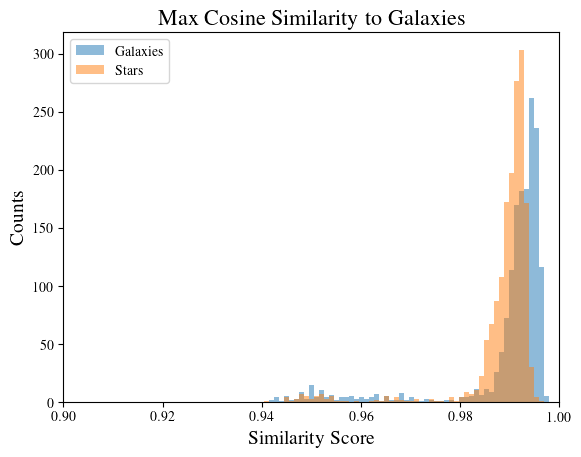

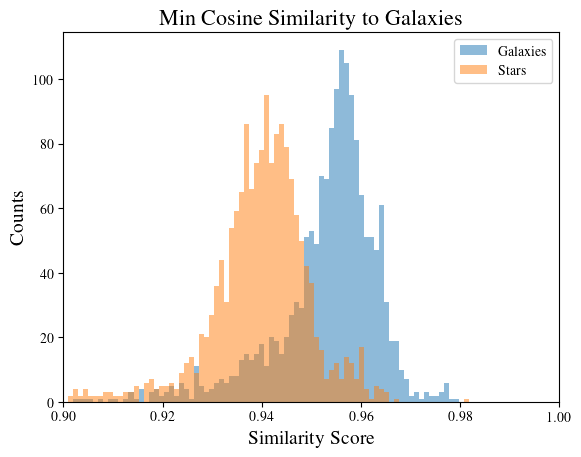

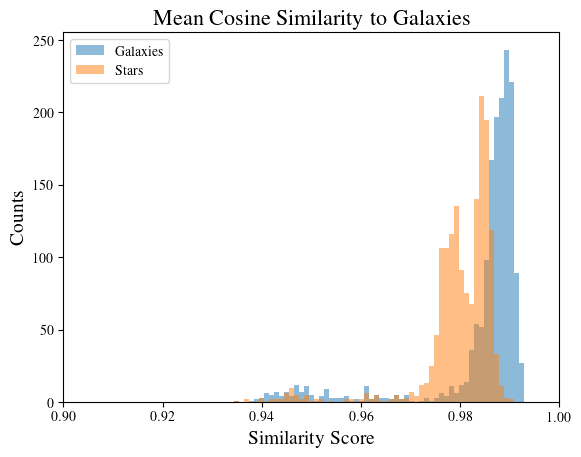

In [3]:
# Try max cosine-similarity
metric = 'cosine'
combine = 'max'

# Compute similarity score for each sample
pos_test_similarity = compute_similarity(target_latent, pos_test_latent, metric, combine, use_weights=True)
neg_test_similarity = compute_similarity(target_latent, neg_test_latent, metric, combine, use_weights=True)

# Plotting the histograms of the two similarities
plot_dual_histogram(pos_test_similarity.data.numpy(), neg_test_similarity.data.numpy(), bins=100, 
                    data1_label='Galaxies', data2_label='Stars', 
                    title=f'{combine.capitalize()} {metric.capitalize()} Similarity to Galaxies',
                   xlim=(0.9,1))

# Try min cosine-similarity
metric = 'cosine'
combine = 'min'

# Compute similarity score for each sample
pos_test_similarity = compute_similarity(target_latent, pos_test_latent, metric, combine, use_weights=True)
neg_test_similarity = compute_similarity(target_latent, neg_test_latent, metric, combine, use_weights=True)

# Plotting the histograms of the two similarities
plot_dual_histogram(pos_test_similarity.data.numpy(), neg_test_similarity.data.numpy(), bins=100, 
                    data1_label='Galaxies', data2_label='Stars', 
                    title=f'{combine.capitalize()} {metric.capitalize()} Similarity to Galaxies',
                   xlim=(0.9,1))

# Try mean cosine-similarity
metric = 'cosine'
combine = 'mean'

# Compute similarity score for each sample
pos_test_similarity = compute_similarity(target_latent, pos_test_latent, metric, combine, use_weights=True)
neg_test_similarity = compute_similarity(target_latent, neg_test_latent, metric, combine, use_weights=True)

# Plotting the histograms of the two similarities
plot_dual_histogram(pos_test_similarity.data.numpy(), neg_test_similarity.data.numpy(), bins=100, 
                    data1_label='Galaxies', data2_label='Stars', 
                    title=f'{combine.capitalize()} {metric.capitalize()} Similarity to Galaxies',
                   xlim=(0.9,1))

### Similarity Metric Comparison

We will compare three metrics:

- **Cosine Similarity**: Measures the cosine of the angle between two vectors, with 1 indicating perfect similarity.
- **Mean-Squared Error (MSE)**: Represents the average of the squares of the differences between the test and target features, with 0 indicating perfect similarity.
- **Mean-Absolute Error (MAE)**: Represents the average of the absolute differences between the test and target features, with 0 also indicating perfect similarity.

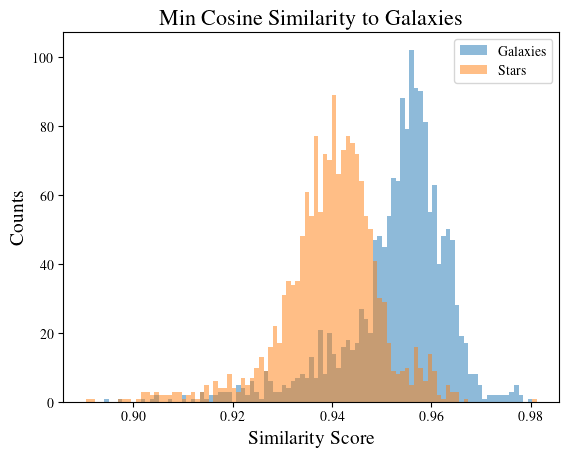

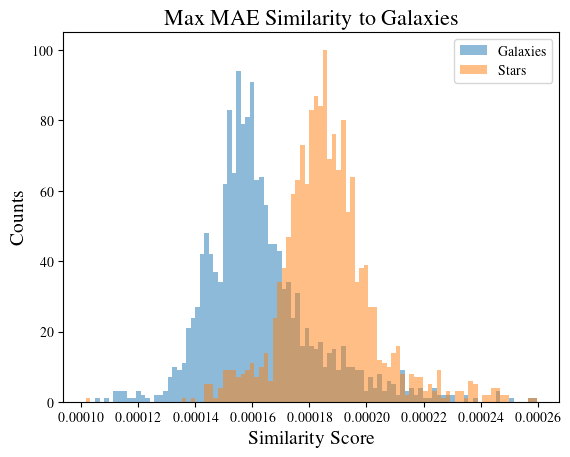

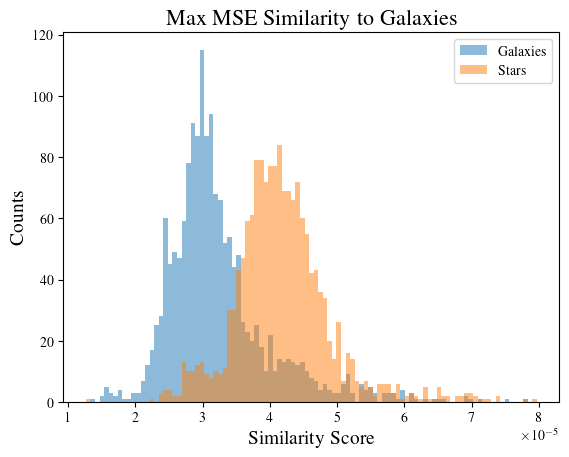

In [4]:
# Try min cosine-similarity
metric = 'cosine'
combine = 'min'

# Compute similarity score for each sample
pos_test_similarity = compute_similarity(target_latent, pos_test_latent, metric, combine, use_weights=True)
neg_test_similarity = compute_similarity(target_latent, neg_test_latent, metric, combine, use_weights=True)

# Plotting the histograms of the two similarities
plot_dual_histogram(pos_test_similarity.data.numpy(), neg_test_similarity.data.numpy(), bins=100, 
                    data1_label='Galaxies', data2_label='Stars', 
                    title=f'{combine.capitalize()} {metric.capitalize()} Similarity to Galaxies',
                   xlim=None)#(0.9,1))

# Try max mean-absolute-error
metric = 'MAE'
combine = 'max'

# Compute similarity score for each sample
pos_test_similarity = compute_similarity(target_latent, pos_test_latent, metric, combine, use_weights=True)
neg_test_similarity = compute_similarity(target_latent, neg_test_latent, metric, combine, use_weights=True)

# Plotting the histograms of the two similarities
plot_dual_histogram(pos_test_similarity.data.numpy(), neg_test_similarity.data.numpy(), bins=100, 
                    data1_label='Galaxies', data2_label='Stars', 
                    title=f'{combine.capitalize()} {metric.upper()} Similarity to Galaxies',
                   xlim=None)#(0.,3e-4))

# Try max mean-squared-error
metric = 'MSE'
combine = 'max'

# Compute similarity score for each sample
pos_test_similarity = compute_similarity(target_latent, pos_test_latent, metric, combine, use_weights=True)
neg_test_similarity = compute_similarity(target_latent, neg_test_latent, metric, combine, use_weights=True)

# Plotting the histograms of the two similarities
plot_dual_histogram(pos_test_similarity.data.numpy(), neg_test_similarity.data.numpy(), bins=100, 
                    data1_label='Galaxies', data2_label='Stars', 
                    title=f'{combine.capitalize()} {metric.upper()} Similarity to Galaxies',
                   xlim=None)#(0.,1e-4))

**To do:** Make this comparison more quantitative.

## Identifying Strong Lens Candidates

Applying our methodology, we aim to identify candidates for [**strong gravitational lensing**](https://en.wikipedia.org/wiki/Strong_gravitational_lensing), a phenomenon where a massive object causes light from a more distant object to bend and form a ring or arc around it.

### Data

- **Reference Images**: We used images of existing strong lens candidates as our reference class, providing a well-defined feature set for comparison.
- **Test Images**: Our test set includes a broad selection of unclassified cosmic objects, potentially containing undiscovered lensing events.

In [ ]:
# Data loaders
target_fn = 'HSC_strong_lens_candidates_GRIZY_64.h5'
control_fn = 'HSC_unkown_GRIZY_64.h5'

target_dataloader = build_dataloader(os.path.join(data_dir, target_fn), 
                              config['DATA']['norm_type'], 
                              16, 
                              0,
                              shuffle=False)
test_dataloader = build_dataloader(os.path.join(data_dir, control_fn), 
                              config['DATA']['norm_type'], 
                              16, 
                              0,
                              shuffle=False)

# Map samples to latent-space
target_latent, target_images = mae_latent(model, target_dataloader, device, n_batches=None, return_images=True)
test_latent, test_images = mae_latent(model, test_dataloader, device, n_batches=400, return_images=True)

# Normalize each feature between 0 and 1
target_latent, test_latent = normalize_latents(target_latent, test_latent)

Encoding 4 batches...
Encoding 400 batches...


### Reference Set Images

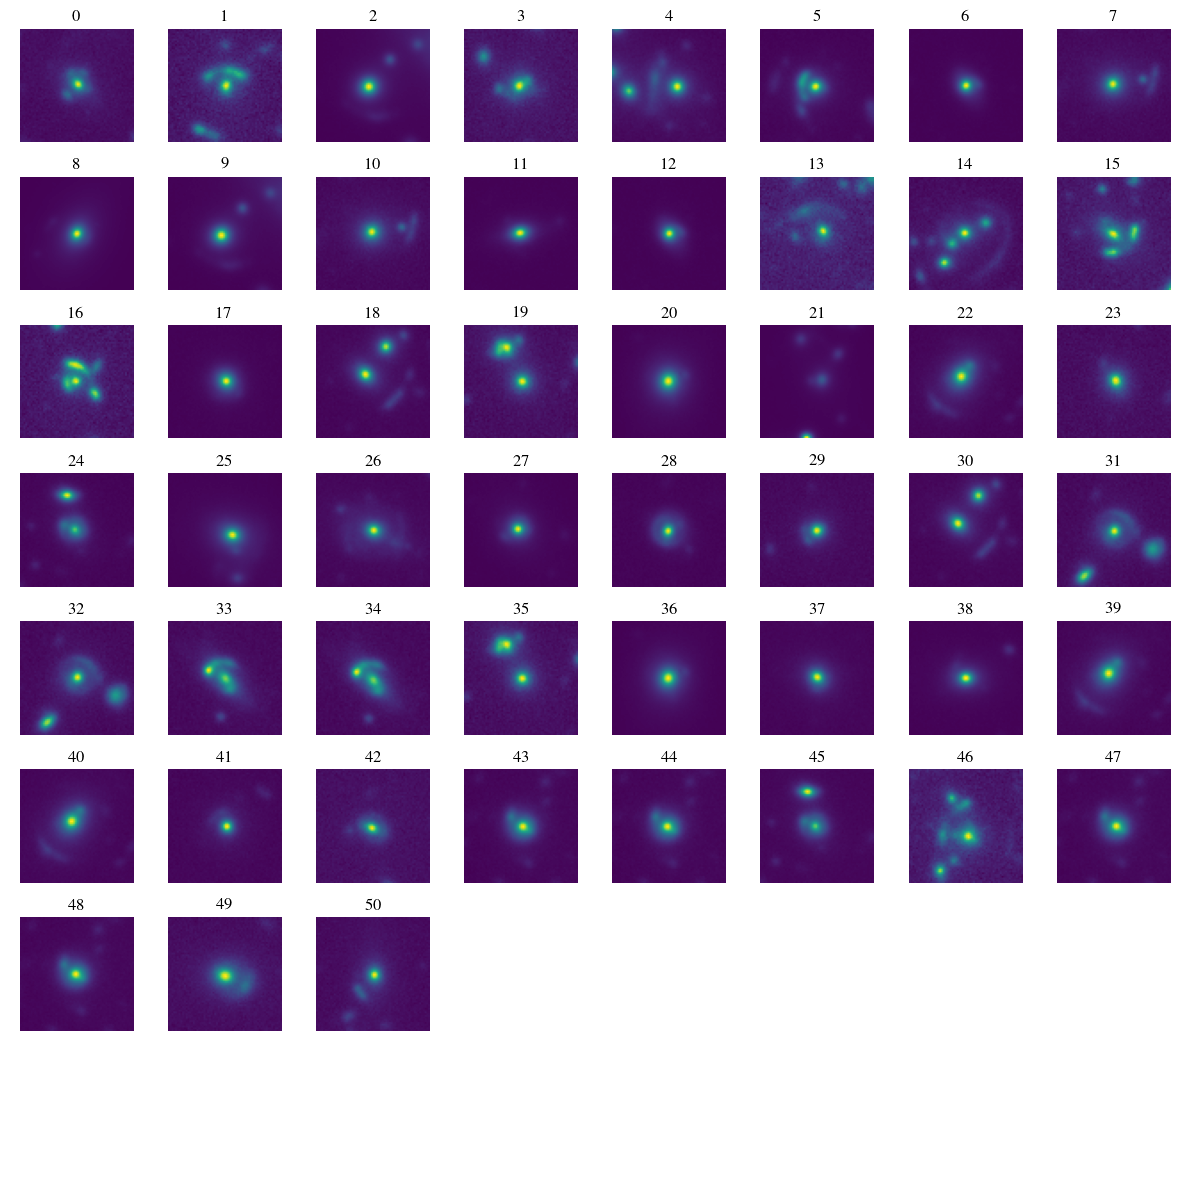

In [6]:
display_channel = 2
display_images(normalize_images(target_images[:,display_channel,:,:].data.numpy()), 
                                vmin=0., vmax=1)

### Find new candidates

We will use the cosine similarity and display the 64 images with the highest similarity.

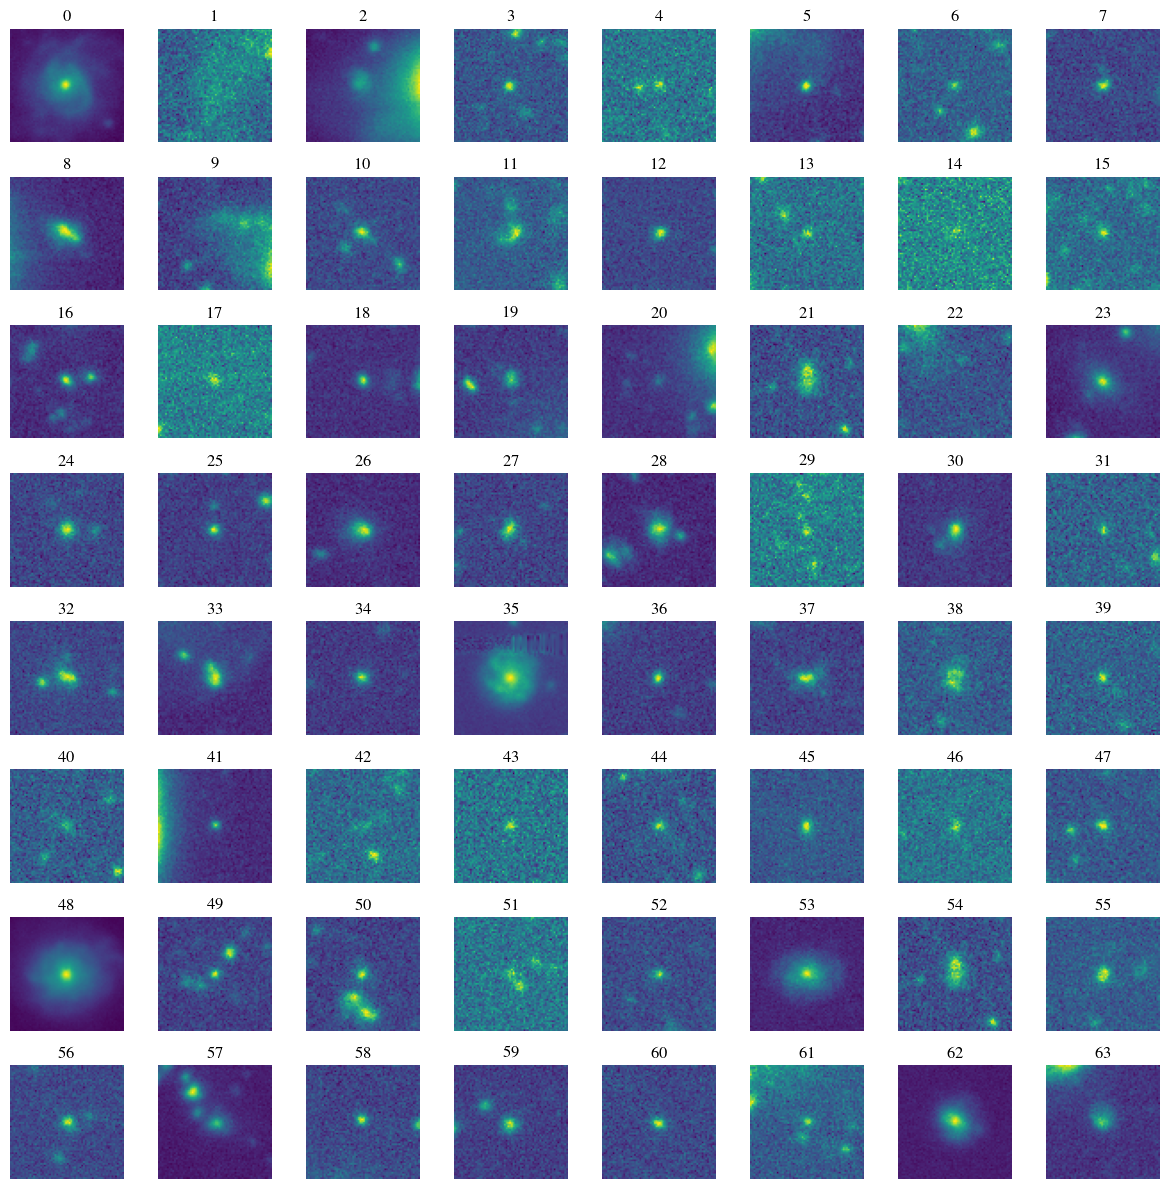

In [7]:
# Try min cosine-similarity
metric = 'cosine'
combine = 'min'

# Compute similarity score for each sample
test_similarity = compute_similarity(target_latent, test_latent, metric, combine, use_weights=True)

# Display top 64 candidates
sim_order = torch.argsort(test_similarity)
if metric=='cosine':
    sim_order = reversed(sim_order)
display_images(normalize_images(test_images[sim_order[:64]][:,display_channel,:,:].data.numpy()))

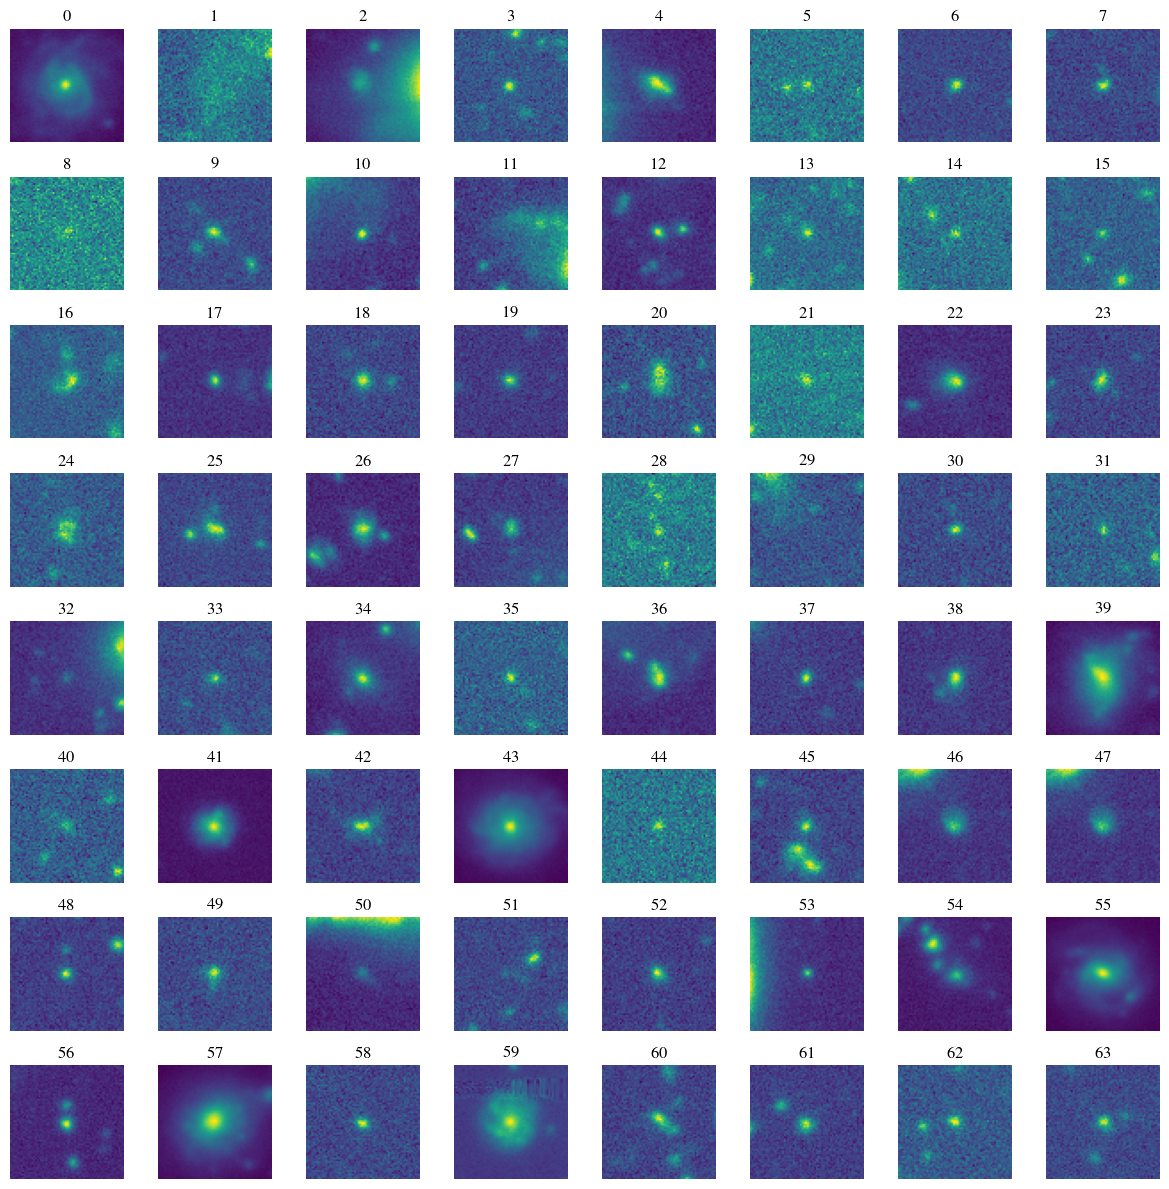

In [8]:
# Try max MAE 
metric = 'MAE'
combine = 'max'

# Compute similarity score for each sample
test_similarity = compute_similarity(target_latent, test_latent, metric, combine, use_weights=True)

# Display top 64 candidates
sim_order = torch.argsort(test_similarity)
if metric=='cosine':
    sim_order = reversed(sim_order)
display_images(normalize_images(test_images[sim_order[:64]][:,display_channel,:,:].data.numpy()))